# 🚀 Vietnamese-English Translation - Single GPU with Resume

**Simple, reliable training with checkpoint resume capability**

## Features:
- ✅ Single GPU (no threading complexity)
- ✅ **Full checkpoint save/resume**
- ✅ 12 epochs
- ✅ Greedy decoding

**Expected Time: ~3 hours on single T4**

## Cell 1: Setup

In [1]:
import os
import sys
import torch
import torch.nn as nn
import pickle
import time
from tqdm import tqdm

# Kaggle paths
CODE_PATH = '/kaggle/input/ml-data'
DATA_PATH = '/kaggle/input/ml-data'
OUTPUT_PATH = '/kaggle/working'
sys.path.insert(0, CODE_PATH)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

os.makedirs(f'{OUTPUT_PATH}/checkpoints', exist_ok=True)

import subprocess
subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', 'sentencepiece'])
print("✅ Setup complete!")

Device: cuda
GPU: Tesla T4
✅ Setup complete!


## Cell 2: Configuration

In [2]:
CONFIG = {
    'model_size': 'tiny',
    'num_epochs': 10,
    'batch_size': 128,
    'learning_rate': 0.0003,
    'use_amp': True,
    'save_every_epochs': 2,  # Save checkpoint every 2 epochs
}

# Set to resume from checkpoint (if exists)
RESUME_CHECKPOINT = '/kaggle/input/model-checkpoint/checkpoint_epoch_6.pt'

for k, v in CONFIG.items():
    print(f"{k}: {v}")

model_size: tiny
num_epochs: 10
batch_size: 128
learning_rate: 0.0003
use_amp: True
save_every_epochs: 2


## Cell 3: Load Tokenizers & Data

In [3]:
from tokenizer_sentencepiece import SentencePieceTokenizer
from dataloader_module import create_dataloaders_with_bucketing

vi_tokenizer = SentencePieceTokenizer(f'{DATA_PATH}/vi_sp.model')
en_tokenizer = SentencePieceTokenizer(f'{DATA_PATH}/en_sp.model')

with open(f'{DATA_PATH}/processed_data.pkl', 'rb') as f:
    processed_data = pickle.load(f)

train_vi_en, val_vi_en, _ = create_dataloaders_with_bucketing(
    processed_data, batch_size=CONFIG['batch_size'], num_workers=2
)

reversed_data = {
    'train': {'src': processed_data['train']['tgt'], 'tgt': processed_data['train']['src']},
    'validation': {'src': processed_data['validation']['tgt'], 'tgt': processed_data['validation']['src']},
    'test': {'src': processed_data['test']['tgt'], 'tgt': processed_data['test']['src']}
}
train_en_vi, val_en_vi, _ = create_dataloaders_with_bucketing(
    reversed_data, batch_size=CONFIG['batch_size'], num_workers=2
)

print(f"Train batches: {len(train_vi_en)}")

✅ Loaded SentencePiece model: /kaggle/input/ml-data/vi_sp.model
   Vocab size: 32000
   PAD_IDX: 0
   UNK_IDX: 1
   SOS_IDX: 2
   EOS_IDX: 3
✅ Loaded SentencePiece model: /kaggle/input/ml-data/en_sp.model
   Vocab size: 32000
   PAD_IDX: 0
   UNK_IDX: 1
   SOS_IDX: 2
   EOS_IDX: 3

TẠO DATALOADERS VỚI BUCKET SAMPLING
✓ Đã tạo DataLoaders với Bucket Sampling
  Bucket Sampling giúp giảm padding, tăng tốc ~15-20%

TẠO DATALOADERS VỚI BUCKET SAMPLING
✓ Đã tạo DataLoaders với Bucket Sampling
  Bucket Sampling giúp giảm padding, tăng tốc ~15-20%
Train batches: 22356


## Cell 4: Create Models

In [4]:
from complete_transformer import create_model

# VI->EN model
model_vi_en, _ = create_model(
    src_vocab_size=len(vi_tokenizer),
    tgt_vocab_size=len(en_tokenizer),
    model_size=CONFIG['model_size'],
    pad_idx=0
)
model_vi_en = model_vi_en.to(device)

# EN->VI model
model_en_vi, _ = create_model(
    src_vocab_size=len(en_tokenizer),
    tgt_vocab_size=len(vi_tokenizer),
    model_size=CONFIG['model_size'],
    pad_idx=0
)
model_en_vi = model_en_vi.to(device)

print(f"Parameters: {sum(p.numel() for p in model_vi_en.parameters()):,}")

Parameters: 28,295,424


## Cell 5: Training with Resume

In [5]:
from torch.amp import autocast, GradScaler

# Setup
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer_vi_en = torch.optim.Adam(model_vi_en.parameters(), lr=CONFIG['learning_rate'])
optimizer_en_vi = torch.optim.Adam(model_en_vi.parameters(), lr=CONFIG['learning_rate'])
scaler = GradScaler('cuda') if CONFIG['use_amp'] else None

history = {'vi_en': [], 'en_vi': []}
start_epoch = 1
best_vi_en = float('inf')
best_en_vi = float('inf')

# RESUME FROM CHECKPOINT
if RESUME_CHECKPOINT and os.path.exists(RESUME_CHECKPOINT):
    print(f"\n📂 Loading checkpoint: {RESUME_CHECKPOINT}")
    ckpt = torch.load(RESUME_CHECKPOINT, map_location=device)
    
    model_vi_en.load_state_dict(ckpt['model_vi_en'])
    model_en_vi.load_state_dict(ckpt['model_en_vi'])
    optimizer_vi_en.load_state_dict(ckpt['optimizer_vi_en'])
    optimizer_en_vi.load_state_dict(ckpt['optimizer_en_vi'])
    if scaler and 'scaler' in ckpt:
        scaler.load_state_dict(ckpt['scaler'])
    
    start_epoch = ckpt['epoch'] + 1
    history = ckpt['history']
    best_vi_en = ckpt['best_vi_en']
    best_en_vi = ckpt['best_en_vi']
    
    print(f"✅ Resumed from epoch {ckpt['epoch']}")
    print(f"   Best VI-EN loss: {best_vi_en:.4f}")
    print(f"   Best EN-VI loss: {best_en_vi:.4f}")
else:
    print("Starting fresh training...")

# TRAINING LOOP
for epoch in range(start_epoch, CONFIG['num_epochs'] + 1):
    print(f"\n{'='*60}\nEpoch {epoch}/{CONFIG['num_epochs']}\n{'='*60}")
    
    model_vi_en.train()
    model_en_vi.train()
    
    total_loss_vi = 0
    total_loss_en = 0
    
    # Interleaved training
    pbar = tqdm(zip(train_vi_en, train_en_vi), total=min(len(train_vi_en), len(train_en_vi)), desc=f'Epoch {epoch}')
    
    for batch_idx, ((src_vi, tgt_vi, _, _), (src_en, tgt_en, _, _)) in enumerate(pbar):
        # Train VI->EN
        src_vi, tgt_vi = src_vi.to(device), tgt_vi.to(device)
        optimizer_vi_en.zero_grad()
        
        if CONFIG['use_amp']:
            with autocast('cuda'):
                out = model_vi_en(src_vi, tgt_vi[:, :-1])
                loss_vi = criterion(out.reshape(-1, out.size(-1)), tgt_vi[:, 1:].reshape(-1))
            scaler.scale(loss_vi).backward()
            scaler.step(optimizer_vi_en)
            scaler.update()
        else:
            out = model_vi_en(src_vi, tgt_vi[:, :-1])
            loss_vi = criterion(out.reshape(-1, out.size(-1)), tgt_vi[:, 1:].reshape(-1))
            loss_vi.backward()
            optimizer_vi_en.step()
        
        # Train EN->VI
        src_en, tgt_en = src_en.to(device), tgt_en.to(device)
        optimizer_en_vi.zero_grad()
        
        if CONFIG['use_amp']:
            with autocast('cuda'):
                out = model_en_vi(src_en, tgt_en[:, :-1])
                loss_en = criterion(out.reshape(-1, out.size(-1)), tgt_en[:, 1:].reshape(-1))
            scaler.scale(loss_en).backward()
            scaler.step(optimizer_en_vi)
            scaler.update()
        else:
            out = model_en_vi(src_en, tgt_en[:, :-1])
            loss_en = criterion(out.reshape(-1, out.size(-1)), tgt_en[:, 1:].reshape(-1))
            loss_en.backward()
            optimizer_en_vi.step()
        
        total_loss_vi += loss_vi.item()
        total_loss_en += loss_en.item()
        
        pbar.set_postfix({'VI-EN': f'{total_loss_vi/(batch_idx+1):.3f}', 'EN-VI': f'{total_loss_en/(batch_idx+1):.3f}'})
    
    # Validation
    model_vi_en.eval()
    model_en_vi.eval()
    
    val_loss_vi = 0
    val_loss_en = 0
    
    with torch.no_grad():
        for src, tgt, _, _ in tqdm(val_vi_en, desc='Val VI-EN', leave=False):
            src, tgt = src.to(device), tgt.to(device)
            out = model_vi_en(src, tgt[:, :-1])
            val_loss_vi += criterion(out.reshape(-1, out.size(-1)), tgt[:, 1:].reshape(-1)).item()
        
        for src, tgt, _, _ in tqdm(val_en_vi, desc='Val EN-VI', leave=False):
            src, tgt = src.to(device), tgt.to(device)
            out = model_en_vi(src, tgt[:, :-1])
            val_loss_en += criterion(out.reshape(-1, out.size(-1)), tgt[:, 1:].reshape(-1)).item()
    
    avg_val_vi = val_loss_vi / len(val_vi_en)
    avg_val_en = val_loss_en / len(val_en_vi)
    
    history['vi_en'].append(avg_val_vi)
    history['en_vi'].append(avg_val_en)
    
    print(f"VI-EN Val Loss: {avg_val_vi:.4f}")
    print(f"EN-VI Val Loss: {avg_val_en:.4f}")
    
    # Save best
    if avg_val_vi < best_vi_en:
        best_vi_en = avg_val_vi
        torch.save(model_vi_en.state_dict(), f'{OUTPUT_PATH}/checkpoints/best_vi_en.pt')
        print("🏆 New best VI-EN!")
    
    if avg_val_en < best_en_vi:
        best_en_vi = avg_val_en
        torch.save(model_en_vi.state_dict(), f'{OUTPUT_PATH}/checkpoints/best_en_vi.pt')
        print("🏆 New best EN-VI!")
    
    # SAVE CHECKPOINT EVERY N EPOCHS
    if epoch % CONFIG['save_every_epochs'] == 0:
        checkpoint = {
            'epoch': epoch,
            'model_vi_en': model_vi_en.state_dict(),
            'model_en_vi': model_en_vi.state_dict(),
            'optimizer_vi_en': optimizer_vi_en.state_dict(),
            'optimizer_en_vi': optimizer_en_vi.state_dict(),
            'scaler': scaler.state_dict() if scaler else None,
            'history': history,
            'best_vi_en': best_vi_en,
            'best_en_vi': best_en_vi,
        }
        ckpt_path = f'{OUTPUT_PATH}/checkpoints/checkpoint_epoch_{epoch}.pt'
        torch.save(checkpoint, ckpt_path)
        print(f"💾 Saved checkpoint: {ckpt_path}")

print("\n🎉 Training Complete!")


📂 Loading checkpoint: /kaggle/input/model-checkpoint/checkpoint_epoch_6.pt
✅ Resumed from epoch 6
   Best VI-EN loss: 1.7691
   Best EN-VI loss: 1.5166

Epoch 7/10


Epoch 7: 100%|██████████| 22356/22356 [1:12:33<00:00,  5.14it/s, VI-EN=1.824, EN-VI=1.598]


VI-EN Val Loss: 1.7510
EN-VI Val Loss: 1.4973
🏆 New best VI-EN!
🏆 New best EN-VI!

Epoch 8/10


Epoch 8: 100%|██████████| 22356/22356 [1:12:06<00:00,  5.17it/s, VI-EN=1.805, EN-VI=1.583]


VI-EN Val Loss: 1.7383
EN-VI Val Loss: 1.4903
🏆 New best VI-EN!
🏆 New best EN-VI!
💾 Saved checkpoint: /kaggle/working/checkpoints/checkpoint_epoch_8.pt

Epoch 9/10


Epoch 9: 100%|██████████| 22356/22356 [1:11:54<00:00,  5.18it/s, VI-EN=1.792, EN-VI=1.570]


VI-EN Val Loss: 1.7279
EN-VI Val Loss: 1.4762
🏆 New best VI-EN!
🏆 New best EN-VI!

Epoch 10/10


Epoch 10: 100%|██████████| 22356/22356 [1:16:55<00:00,  4.84it/s, VI-EN=1.794, EN-VI=1.562]


VI-EN Val Loss: 1.7139
EN-VI Val Loss: 1.4752
🏆 New best VI-EN!
🏆 New best EN-VI!
💾 Saved checkpoint: /kaggle/working/checkpoints/checkpoint_epoch_10.pt

🎉 Training Complete!


## Cell 6: Evaluation

In [6]:
def greedy_translate(model, sentence, src_tok, tgt_tok, device, max_len=100):
    model.eval()
    src_ids = src_tok.encode(sentence)
    src_tensor = torch.tensor([src_ids]).to(device)
    
    with torch.no_grad():
        enc_out, src_mask = model.encode(src_tensor)
    
    tgt_ids = [tgt_tok.SOS_IDX]
    for _ in range(max_len):
        tgt_tensor = torch.tensor([tgt_ids]).to(device)
        with torch.no_grad():
            out = model.decode(tgt_tensor, enc_out, src_mask)
        next_token = out[0, -1].argmax().item()
        if next_token == tgt_tok.EOS_IDX:
            break
        tgt_ids.append(next_token)
    return tgt_tok.decode(tgt_ids[1:])

# Load best
model_vi_en.load_state_dict(torch.load(f'{OUTPUT_PATH}/checkpoints/best_vi_en.pt'))
model_en_vi.load_state_dict(torch.load(f'{OUTPUT_PATH}/checkpoints/best_en_vi.pt'))

# Test
test_vi = ["xin chào, tôi là sinh viên"]
test_en = ["hello, i am a student"]

print("VI → EN:")
for s in test_vi:
    print(f"  {s} → {greedy_translate(model_vi_en, s, vi_tokenizer, en_tokenizer, device)}")

print("\nEN → VI:")
for s in test_en:
    print(f"  {s} → {greedy_translate(model_en_vi, s, en_tokenizer, vi_tokenizer, device)}")

VI → EN:
  xin chào, tôi là sinh viên → hello, i'm a student.

EN → VI:
  hello, i am a student → xin chào, tôi là một sinh viên


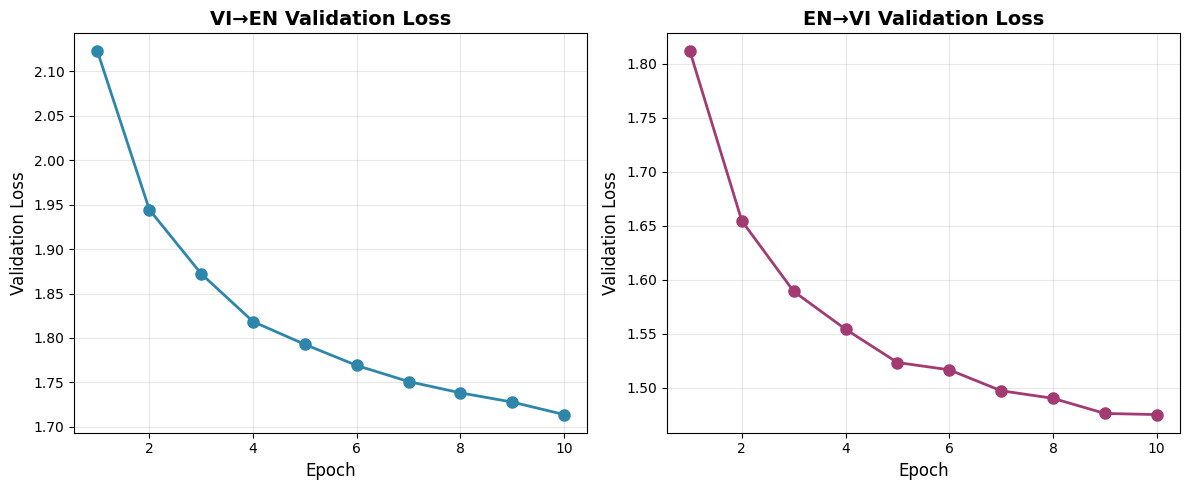

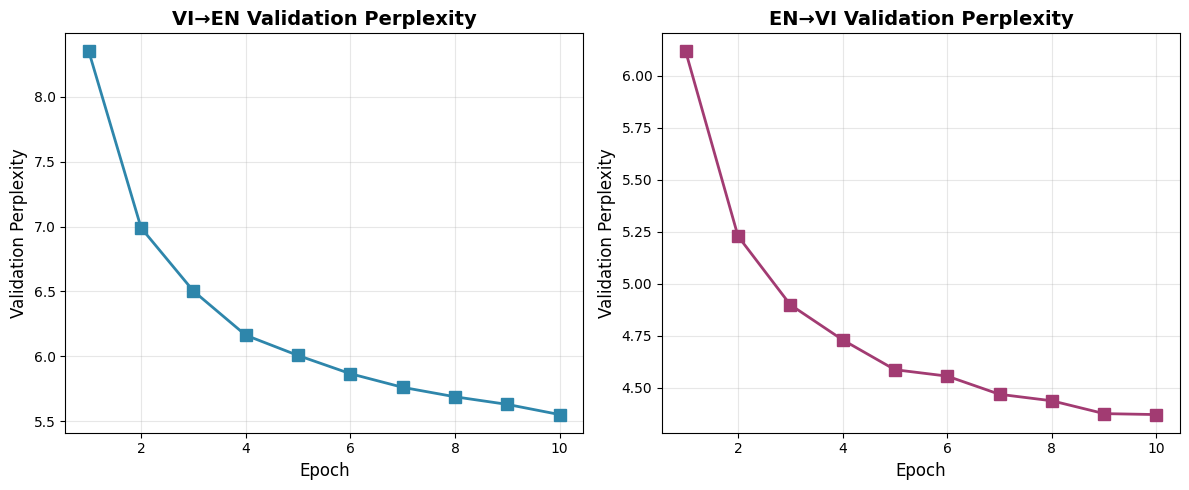

📊 Training Summary:
   Total Epochs: 10
   Best VI→EN Val Loss: 1.7139 (Epoch 10)
   Best EN→VI Val Loss: 1.4752 (Epoch 10)
   Final VI→EN Val Loss: 1.7139
   Final EN→VI Val Loss: 1.4752


In [8]:
# Visualize Training Progress (Validation Loss)
import matplotlib.pyplot as plt
import numpy as np

# Check if history exists
if 'history' in globals() and history:
    # Handle both dict structures
    if isinstance(history['vi_en'], list):
        # Simple list structure (current notebook)
        val_loss_vi_en = history['vi_en']
        val_loss_en_vi = history['en_vi']
    elif isinstance(history['vi_en'], dict):
        # Dict structure with train/val
        val_loss_vi_en = history['vi_en']['val_loss']
        val_loss_en_vi = history['en_vi']['val_loss']
    
    epochs = range(1, len(val_loss_vi_en) + 1)
    
    # Plot Validation Loss
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, val_loss_vi_en, 'o-', linewidth=2, markersize=8, color='#2E86AB')
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("Validation Loss", fontsize=12)
    plt.title("VI→EN Validation Loss", fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_loss_en_vi, 'o-', linewidth=2, markersize=8, color='#A23B72')
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("Validation Loss", fontsize=12)
    plt.title("EN→VI Validation Loss", fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Plot Validation Perplexity
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    val_ppl_vi_en = [np.exp(loss) for loss in val_loss_vi_en]
    plt.plot(epochs, val_ppl_vi_en, 's-', linewidth=2, markersize=8, color='#2E86AB')
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("Validation Perplexity", fontsize=12)
    plt.title("VI→EN Validation Perplexity", fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    val_ppl_en_vi = [np.exp(loss) for loss in val_loss_en_vi]
    plt.plot(epochs, val_ppl_en_vi, 's-', linewidth=2, markersize=8, color='#A23B72')
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("Validation Perplexity", fontsize=12)
    plt.title("EN→VI Validation Perplexity", fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print("📊 Training Summary:")
    print(f"   Total Epochs: {len(epochs)}")
    print(f"   Best VI→EN Val Loss: {min(val_loss_vi_en):.4f} (Epoch {val_loss_vi_en.index(min(val_loss_vi_en)) + 1})")
    print(f"   Best EN→VI Val Loss: {min(val_loss_en_vi):.4f} (Epoch {val_loss_en_vi.index(min(val_loss_en_vi)) + 1})")
    print(f"   Final VI→EN Val Loss: {val_loss_vi_en[-1]:.4f}")
    print(f"   Final EN→VI Val Loss: {val_loss_en_vi[-1]:.4f}")
else:
    print("⚠️ No history found. It may have been lost when the notebook restarted.")
    print("\nOption 1: If you have a checkpoint file:")
    print("  ckpt = torch.load('/kaggle/working/checkpoints/checkpoint_epoch_X.pt')")
    print("  history = ckpt['history']")
    print("  # Then run this cell again")
    print("\nOption 2: Training loss wasn't tracked, so we can't recover it")

In [10]:
# ==== Cell: Load Best Models & BLEU Evaluation (Limited to 500 sentences) ====

import torch
from inference_evaluation_v2 import calculate_corpus_bleu

print("=" * 60)
print("📊 LOADING BEST MODELS & BLEU EVALUATION")
print("=" * 60)

# Load best models
print("\n🔄 Loading best models...")
model_vi_en.load_state_dict(torch.load(f'{OUTPUT_PATH}/checkpoints/best_vi_en.pt', map_location=device))
model_en_vi.load_state_dict(torch.load(f'{OUTPUT_PATH}/checkpoints/best_en_vi.pt', map_location=device))
model_vi_en.eval()
model_en_vi.eval()
print("✅ Models loaded!")

# Load test data
_, _, test_vi_en = create_dataloaders_with_bucketing(
    processed_data, batch_size=CONFIG['batch_size'], num_workers=2
)
reversed_test = {
    'train': processed_data['train'], 
    'validation': processed_data['validation'],
    'test': {'src': processed_data['test']['tgt'], 'tgt': processed_data['test']['src']}
}
_, _, test_en_vi = create_dataloaders_with_bucketing(
    reversed_test, batch_size=CONFIG['batch_size'], num_workers=2
)

# Test translations (5 examples)
print("\n" + "=" * 60)
print("🧪 TESTING TRANSLATIONS (5 samples)")
print("=" * 60)

test_samples_vi = [
    "xin chào, tôi là sinh viên",
    "hôm nay trời đẹp quá",
    "tôi thích học tiếng anh",
    "chúng tôi đang làm việc ở văn phòng",
    "bạn có thể giúp tôi không?"
]

test_samples_en = [
    "hello, i am a student",
    "the weather is nice today",
    "i like learning english",
    "we are working at the office",
    "can you help me?"
]

print("\n🇻🇳 → 🇬🇧 VI→EN Translations:")
for i, src in enumerate(test_samples_vi, 1):
    pred = greedy_translate(model_vi_en, src, vi_tokenizer, en_tokenizer, device)
    print(f"\n{i}. SRC: {src}")
    print(f"   PRED: {pred}")

print("\n🇬🇧 → 🇻🇳 EN→VI Translations:")
for i, src in enumerate(test_samples_en, 1):
    pred = greedy_translate(model_en_vi, src, en_tokenizer, vi_tokenizer, device)
    print(f"\n{i}. SRC: {src}")
    print(f"   PRED: {pred}")

# BLEU Evaluation (limited to 500 sentences)
TEST_LIMIT = 500

print("\n" + "=" * 60)
print(f"📊 BLEU EVALUATION (Limited to {TEST_LIMIT} sentences)")
print("=" * 60)

# VI→EN BLEU
print("\n🇻🇳 → 🇬🇧 Evaluating VI→EN BLEU...")
refs_en = []
preds_en = []
src_vi_list = []  # Save for Gemini later
count = 0

with torch.no_grad():
    for src, tgt, _, _ in tqdm(test_vi_en, desc="VI→EN"):
        if count >= TEST_LIMIT:
            break
        
        for i in range(src.size(0)):
            if count >= TEST_LIMIT:
                break
            
            src_sent = vi_tokenizer.decode(src[i].tolist())
            ref_sent = en_tokenizer.decode([t for t in tgt[i].tolist() if t != 0])
            pred_sent = greedy_translate(model_vi_en, src_sent, vi_tokenizer, en_tokenizer, device)
            
            src_vi_list.append(src_sent)
            refs_en.append(ref_sent)
            preds_en.append(pred_sent)
            count += 1

bleu_vi_en = calculate_corpus_bleu(refs_en, preds_en)

# EN→VI BLEU
print("\n🇬🇧 → 🇻🇳 Evaluating EN→VI BLEU...")
refs_vi = []
preds_vi = []
src_en_list = []  # Save for Gemini later
count = 0

with torch.no_grad():
    for src, tgt, _, _ in tqdm(test_en_vi, desc="EN→VI"):
        if count >= TEST_LIMIT:
            break
        
        for i in range(src.size(0)):
            if count >= TEST_LIMIT:
                break
            
            src_sent = en_tokenizer.decode(src[i].tolist())
            ref_sent = vi_tokenizer.decode([t for t in tgt[i].tolist() if t != 0])
            pred_sent = greedy_translate(model_en_vi, src_sent, en_tokenizer, vi_tokenizer, device)
            
            src_en_list.append(src_sent)
            refs_vi.append(ref_sent)
            preds_vi.append(pred_sent)
            count += 1

bleu_en_vi = calculate_corpus_bleu(refs_vi, preds_vi)

# Results
print("\n" + "=" * 60)
print("🎯 FINAL BLEU SCORES")
print("=" * 60)
print(f"VI→EN BLEU: {bleu_vi_en['corpus_bleu']:.2f} (on {len(refs_en)} sentences)")
print(f"EN→VI BLEU: {bleu_en_vi['corpus_bleu']:.2f} (on {len(refs_vi)} sentences)")
print(f"Average BLEU: {(bleu_vi_en['corpus_bleu'] + bleu_en_vi['corpus_bleu']) / 2:.2f}")
print("=" * 60)

# Show a few examples
print("\n🔍 Sample Translations:")
print("\n--- VI→EN Examples ---")
for i in range(min(3, len(src_vi_list))):
    print(f"\n{i+1}. SRC: {src_vi_list[i]}")
    print(f"   REF: {refs_en[i]}")
    print(f"   PRED: {preds_en[i]}")

print("\n--- EN→VI Examples ---")
for i in range(min(3, len(src_en_list))):
    print(f"\n{i+1}. SRC: {src_en_list[i]}")
    print(f"   REF: {refs_vi[i]}")
    print(f"   PRED: {preds_vi[i]}")

print("\n✅ Evaluation complete!")
print(f"📝 Note: src_vi_list, refs_en, preds_en saved for Gemini scoring")

📊 LOADING BEST MODELS & BLEU EVALUATION

🔄 Loading best models...
✅ Models loaded!

TẠO DATALOADERS VỚI BUCKET SAMPLING
✓ Đã tạo DataLoaders với Bucket Sampling
  Bucket Sampling giúp giảm padding, tăng tốc ~15-20%

TẠO DATALOADERS VỚI BUCKET SAMPLING
✓ Đã tạo DataLoaders với Bucket Sampling
  Bucket Sampling giúp giảm padding, tăng tốc ~15-20%

🧪 TESTING TRANSLATIONS (5 samples)

🇻🇳 → 🇬🇧 VI→EN Translations:

1. SRC: xin chào, tôi là sinh viên
   PRED: hello, i'm a student.

2. SRC: hôm nay trời đẹp quá
   PRED: it's beautiful today.

3. SRC: tôi thích học tiếng anh
   PRED: i love to learn english.

4. SRC: chúng tôi đang làm việc ở văn phòng
   PRED: we're working at the office.

5. SRC: bạn có thể giúp tôi không?
   PRED: can you help me?

🇬🇧 → 🇻🇳 EN→VI Translations:

1. SRC: hello, i am a student
   PRED: xin chào, tôi là một sinh viên

2. SRC: the weather is nice today
   PRED: thời tiết đẹp hôm nay

3. SRC: i like learning english
   PRED: tôi thích học tiếng anh

4. SRC: we are 

VI→EN:   0%|          | 4/2792 [00:51<9:53:00, 12.76s/it] 



🇬🇧 → 🇻🇳 Evaluating EN→VI BLEU...


EN→VI:   0%|          | 4/2792 [00:59<11:25:45, 14.76s/it]



🎯 FINAL BLEU SCORES
VI→EN BLEU: 31.95 (on 500 sentences)
EN→VI BLEU: 40.52 (on 500 sentences)
Average BLEU: 36.23

🔍 Sample Translations:

--- VI→EN Examples ---

1. SRC: " well, ai thế? " bernard hét. '
   REF: " well, who, then? " bernard shouted. '
   PRED: " well, who is that? " bernard shouted. '

2. SRC: 1. xây dựng định hướng chiến lược phát triển và chỉ đạo tổ chức, hoạt động của nhà trường. xây dựng và ban hành các quy định về chế độ, tiêu chuẩn, định mức thu, chi tài chính của trường phù hợp với quy định của pháp luật và chế độ quản lý tài chính. huy động các nguồn vốn đầu tư xây dựng trường, phê duyệt dự toán, quyết toán tài chính hàng năm và giám sát việc quản lý, sử dụng tài chính, tài
   REF: 3. to nominate principal for head of the district department of education and training to review, and make the decision on recognition; to appoint vice principal as nominated by the principal; to approve the general plan of organization of apparatus, staffing and other issues relate

In [11]:
# ==== Cell 9: Gemini Score (batch scoring with Kaggle Secrets) ====

!pip install -q google-generativeai

import json, re
import numpy as np
from tqdm.auto import tqdm
import google.generativeai as genai
from kaggle_secrets import UserSecretsClient

# --- Get API from Kaggle Secrets ---
user_secrets = UserSecretsClient()
API_KEY = user_secrets.get_secret("GEMINI_API_KEY")  # Secret name in Kaggle

if not API_KEY:
    print("⚠️  No GEMINI_API_KEY found in Kaggle Secrets")
    print("Add it at: Kaggle Notebook → Add-ons → Secrets → + New Secret")
    print("Name: GEMINI_API_KEY")
    print("Value: Your API key from https://aistudio.google.com/app/apikey")
else:
    genai.configure(api_key=API_KEY)
    
    MODEL_ID = "gemini-flash-latest"
    gemini_model = genai.GenerativeModel(MODEL_ID)
    print("✔ Gemini model ready:", MODEL_ID)
    
    # --- Prepare data for scoring ---
    # We need source sentences - get them from test data
    src_vi_list = []
    src_en_list = []
    
    # Rebuild source lists from test loaders
    for src, tgt, _, _ in test_vi_en:
        for i in range(src.size(0)):
            src_vi_list.append(vi_tokenizer.decode(src[i].tolist()))
    
    for src, tgt, _, _ in test_en_vi:
        for i in range(src.size(0)):
            src_en_list.append(en_tokenizer.decode(src[i].tolist()))
    
    # VI→EN Scoring
    print("\n🇻🇳 → 🇬🇧 Gemini VI→EN Evaluation")
    
    MAX_GEMINI_SAMPLES = 100  # Adjust based on quota
    BATCH_SIZE = 10           # Sentences per request
    
    n_vi_en = min(MAX_GEMINI_SAMPLES, len(src_vi_list), len(refs_en), len(preds_en))
    
    print(f"Scoring {n_vi_en} translations, {BATCH_SIZE} per batch...")
    
    scores_vi_en = []
    
    for start in tqdm(range(0, n_vi_en, BATCH_SIZE), desc="Gemini VI→EN"):
        end = min(start + BATCH_SIZE, n_vi_en)
        batch_indices = list(range(start, end))
        
        # Create batch prompt
        items_text = []
        for local_i, idx in enumerate(batch_indices, start=1):
            items_text.append(f"""Item {local_i}:
Source (Vietnamese):
{src_vi_list[idx]}

Reference (English):
{refs_en[idx]}

Candidate (English):
{preds_en[idx]}
""")
        
        batch_prompt = f"""You are evaluating Vietnamese → English translations.

For each item, compare the candidate with the reference for meaning, fluency, and grammar.

Score each from 0 to 1 (0=wrong, 1=perfect).

Return ONLY a JSON array of numbers: [score1, score2, ...]

{"".join(items_text)}"""
        
        resp = gemini_model.generate_content(batch_prompt)
        text = resp.text.strip()
        
        # Parse JSON scores
        try:
            batch_scores = json.loads(text)
        except:
            nums = re.findall(r"(\d+(?:\.\d+)?)", text)
            batch_scores = [float(x) for x in nums]
        
        # Ensure correct length
        if len(batch_scores) < len(batch_indices):
            batch_scores += [0.0] * (len(batch_indices) - len(batch_scores))
        batch_scores = batch_scores[:len(batch_indices)]
        
        # Clamp to [0, 1]
        batch_scores = [max(0.0, min(1.0, float(s))) for s in batch_scores]
        scores_vi_en.extend(batch_scores)
    
    scores_vi_en = np.array(scores_vi_en)
    
    # EN→VI Scoring
    print("\n🇬🇧 → 🇻🇳 Gemini EN→VI Evaluation")
    
    n_en_vi = min(MAX_GEMINI_SAMPLES, len(src_en_list), len(refs_vi), len(preds_vi))
    
    print(f"Scoring {n_en_vi} translations, {BATCH_SIZE} per batch...")
    
    scores_en_vi = []
    
    for start in tqdm(range(0, n_en_vi, BATCH_SIZE), desc="Gemini EN→VI"):
        end = min(start + BATCH_SIZE, n_en_vi)
        batch_indices = list(range(start, end))
        
        items_text = []
        for local_i, idx in enumerate(batch_indices, start=1):
            items_text.append(f"""Item {local_i}:
Source (English):
{src_en_list[idx]}

Reference (Vietnamese):
{refs_vi[idx]}

Candidate (Vietnamese):
{preds_vi[idx]}
""")
        
        batch_prompt = f"""You are evaluating English → Vietnamese translations.

For each item, compare the candidate with the reference for meaning, fluency, and grammar.

Score each from 0 to 1 (0=wrong, 1=perfect).

Return ONLY a JSON array of numbers: [score1, score2, ...]

{"".join(items_text)}"""
        
        resp = gemini_model.generate_content(batch_prompt)
        text = resp.text.strip()
        
        try:
            batch_scores = json.loads(text)
        except:
            nums = re.findall(r"(\d+(?:\.\d+)?)", text)
            batch_scores = [float(x) for x in nums]
        
        if len(batch_scores) < len(batch_indices):
            batch_scores += [0.0] * (len(batch_indices) - len(batch_indices))
        batch_scores = batch_scores[:len(batch_indices)]
        
        batch_scores = [max(0.0, min(1.0, float(s))) for s in batch_scores]
        scores_en_vi.extend(batch_scores)
    
    scores_en_vi = np.array(scores_en_vi)
    
    # Results
    print("\n" + "=" * 60)
    print("🤖 GEMINI EVALUATION RESULTS")
    print("=" * 60)
    print(f"\n🇻🇳 → 🇬🇧 VI→EN:")
    print(f"  Samples scored: {len(scores_vi_en)}")
    print(f"  Gemini Score (0-1):   {scores_vi_en.mean():.3f}")
    print(f"  Gemini Score (0-100): {scores_vi_en.mean() * 100:.2f}")
    
    print(f"\n🇬🇧 → 🇻🇳 EN→VI:")
    print(f"  Samples scored: {len(scores_en_vi)}")
    print(f"  Gemini Score (0-1):   {scores_en_vi.mean():.3f}")
    print(f"  Gemini Score (0-100): {scores_en_vi.mean() * 100:.2f}")
    
    avg_gemini = (scores_vi_en.mean() + scores_en_vi.mean()) / 2
    print(f"\n🌟 Average Gemini Score: {avg_gemini * 100:.2f}/100")
    print("=" * 60)

✔ Gemini model ready: gemini-flash-latest

🇻🇳 → 🇬🇧 Gemini VI→EN Evaluation
Scoring 100 translations, 10 per batch...


Gemini VI→EN:   0%|          | 0/10 [00:00<?, ?it/s]


🇬🇧 → 🇻🇳 Gemini EN→VI Evaluation
Scoring 100 translations, 10 per batch...


Gemini EN→VI:   0%|          | 0/10 [00:00<?, ?it/s]


🤖 GEMINI EVALUATION RESULTS

🇻🇳 → 🇬🇧 VI→EN:
  Samples scored: 100
  Gemini Score (0-1):   0.546
  Gemini Score (0-100): 54.60

🇬🇧 → 🇻🇳 EN→VI:
  Samples scored: 100
  Gemini Score (0-1):   0.642
  Gemini Score (0-100): 64.20

🌟 Average Gemini Score: 59.40/100
